In [ ]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=26fe35bef083b1c758117484f35202d87aa0ca6ddcd917a743165827eb9f20fb
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import umap as ump
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score as ss
from sklearn.cluster import KMeans
from google.colab import drive
import os
from os import listdir

print('Successful imports')

Successful imports


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Machine Learning in healthcare/Final project'

/content/gdrive/MyDrive/Machine Learning in healthcare/Final project


## Feature selection

In [ ]:
data = pd.read_csv('Eureca_Adapted.csv', low_memory=False)

In [ ]:
km = data[extra]

In [ ]:
all = data.columns
cols = []

In [ ]:
# series of interesting information,
mixture = ['type', 'suicide', 'gender']

In [ ]:
# BDHI and BIS scales
BDHIS = [col for col in all if ("BDHI_" in col)] # usando subtotales BDHI_,
BIS = [col for col in all if ("BIS10_" in col)] # cogemos subtotales latentes BIS, resultado final es suma de los tres subtotales

In [ ]:
print(BDHIS)
print(BIS)

['BDHI_Impul', 'BDHI_Hostind', 'BDHI_Irritab', 'BDHI_Negativ', 'BDHI_Ressent', 'BDHI_Suspic', 'BDHI_Hostivb', 'BDHI_Culpab']
['BIS10_Impulc', 'BIS10_Impulm', 'BIS10_impulnp']


In [ ]:
# polymorphisms and other data are in the last 30 variables
extra = list(data.columns[-26:])
for col in mixture +  BDHIS +  BIS + extra:
  cols.append(col)


In [ ]:
print(f"Original data dimension: {len(all)}")
print(f"Current subset dimension: {len(cols)}")


Original data dimension: 604
Current subset dimension: 40


In [ ]:
df_cleaned = data.copy()

# Replace empty strings with NaN in the specified columns for the copy
df_cleaned[BDHIS] = df_cleaned[BDHIS].replace('', pd.NA)

# Create a 'flag' column to check for missing values in specified columns in the original DataFrame
data['missing BDHIS'] = df_cleaned[BDHIS].isnull().any(axis=1)


In [ ]:
df_cleaned = data.copy()

# Replace empty strings with NaN in the specified columns for the copy
df_cleaned[BIS] = df_cleaned[BIS].replace('', pd.NA)

# Create a 'flag' column to check for missing values in specified columns in the original DataFrame
data['missing BIS'] = df_cleaned[BIS].isnull().any(axis=1)


In [ ]:
FLAGS = ['missing BIS', 'missing BDHIS']

In [ ]:
reducedFeatures = mixture + BIS + BDHIS + extra + FLAGS
# save feature subset
subset = data[reducedFeatures]
subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
subset.drop(columns=BIS, inplace=True)

subset.to_csv('Eureca2.0.csv', index=False)

<ipython-input-15-c2849209e3df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
<ipython-input-15-c2849209e3df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=BIS, inplace=True)


## Exploratory Data analysis: Understanding of our data

## Patient profiling

In this section we profile patients based on different clustering and dimensionality reduction schemes.

In [ ]:
# reading feature subset
df = pd.read_csv('Eureca2.0.csv')

In [ ]:
missing_values = df.isnull().sum()

# Display the result
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
type                    0
suicide                 0
gender                  0
BDHI_Impul              0
BDHI_Hostind            0
BDHI_Irritab            0
BDHI_Negativ            0
BDHI_Ressent            0
BDHI_Suspic             0
BDHI_Hostivb            0
BDHI_Culpab             0
COMT                    0
HT1A                    0
HT1B_161                0
HT1B_861                0
VHT2A_1438              0
VHT2A_C102T             0
VHTTP_mutation_seule    0
VHTTP_LPR               0
@_httpb_promoteur       0
VHTTP_snippassocie      0
VHTTP_Intron2           0
TPH1_intron1b           0
TPH1_promo              0
TPH1_Intron3            0
TPH1_Intron4            0
TPH1_Intron7            0
TPH1_Intron9            0
TPH1_T8687              0
TPH2_8997               0
TPH2_9000_Eco72_1       0
TPH2_9000_Aci_I         0
TPH2_Intron5            0
TPH2_Exon7              0
TPH2_Intron9            0
MAOA_Promo              0
MAOA_promo_activite     0
missing

In [ ]:
df.head()

,type,suicide,gender,BDHI_Impul,BDHI_Hostind,BDHI_Irritab,BDHI_Negativ,BDHI_Ressent,BDHI_Suspic,BDHI_Hostivb,...,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,missing BIS,missing BDHIS,BIS
0,12,0,0,8,2,9,1,6,4,6,...,AA,GG,,GG,,2 3,B H,False,False,311228
1,7,,1,8,5,8,2,6,9,7,...,AA,,,AG,,2,H,False,False,281931
2,12,0,1,7,7,7,5,6,6,13,...,AA,GG,,GG,,2,H,False,False,152418
3,12,0,0,7,,11,3,5,,12,...,,,,,,,,False,False,40
4,11,,1,,,,,,,,...,,,,,,2,H,False,False,


#### UMAP + GMM


UMAP works by modeling the relationships between data points in the high-dimensional space and finding a low-dimensional representation that preserves these relationships. Unlike traditional methods like t-SNE, UMAP provides a more scalable and computationally efficient solution.


______
1. The first issue tackled lies in the fact that UMAP only works with numeric variables, but that is not the case in our dataset. The variables corresponding to the polymorphisms take a very small subset of different nucleotide combinations, dummy variable encoding is therefore used.

In [ ]:

from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA


class Embedder:
    def __init__(self, model_name, num_components=1, max_length=32):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_components = num_components
        self.max_length = max_length

    def _get_bert_embeddings(self, documents):
        tokenized_texts = [self.tokenizer(document, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length) for document in documents]
        input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
        attention_mask = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)

        with torch.no_grad():
            output = self.model(input_ids, attention_mask=attention_mask)

        embeddings = output.last_hidden_state.mean(dim=1).numpy()
        print('Embeddings successfully completed')
        return embeddings
    def fit_transform(self, documents):
        embeddings = self._get_bert_embeddings(documents)

        # Reduce dimensionality to 1D using PCA
        pca = PCA(n_components=self.num_components)
        reduced_embeddings = pca.fit_transform(embeddings)

        return reduced_embeddings

In [ ]:
df.head()

,type,suicide,gender,BDHI_Impul,BDHI_Hostind,BDHI_Irritab,BDHI_Negativ,BDHI_Ressent,BDHI_Suspic,BDHI_Hostivb,...,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,missing BIS,missing BDHIS,BIS
0,12,0,0,8,2,9,1,6,4,6,...,AA,GG,,GG,,2 3,B H,False,False,311228
1,7,,1,8,5,8,2,6,9,7,...,AA,,,AG,,2,H,False,False,281931
2,12,0,1,7,7,7,5,6,6,13,...,AA,GG,,GG,,2,H,False,False,152418
3,12,0,0,7,,11,3,5,,12,...,,,,,,,,False,False,40
4,11,,1,,,,,,,,...,,,,,,2,H,False,False,


In [ ]:
import copy


# don't run this unless you don't have copy of dataset, there is a reading cell below already
embd = Embedder('bert-base-uncased')
scols= df.select_dtypes(include=['object']).columns
df2 = df.copy()
for col in scols:
  # compute embeddings of list of unique values and perform replacement
  documents = df[col].unique().tolist()
  values = embd.fit_transform(documents)
  rep = dict(zip(documents, values))
  df2[col] = df2[col].replace(rep)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings suc

In [ ]:
# saving encoded version
df2.to_csv('Eureca2.0_embed.csv')

In [ ]:
# read
# df2 = pd.read_csv('Eureca2.0_embed.csv')

In [ ]:
df2.head()


,type,suicide,gender,BDHI_Impul,BDHI_Hostind,BDHI_Irritab,BDHI_Negativ,BDHI_Ressent,BDHI_Suspic,BDHI_Hostivb,...,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,missing BIS,missing BDHIS,BIS
0,12,-3.910703,-3.910702,-2.069666,-2.035903,-2.331749,-0.406058,-2.553181,-2.374489,-2.690928,...,-3.173865,-0.246838,6.457104,-0.246840,5.871696,-1.741170,0.059035,False,False,-1.482591
1,7,5.317614,-1.406909,-2.069666,-2.140365,-1.810316,-1.663433,-2.553181,-1.543597,-2.509459,...,-3.173865,5.496552,6.457104,-0.164054,5.871696,-1.629902,-2.062470,False,False,-1.861552
2,12,-3.910703,-1.406909,-2.639324,-2.141303,-2.487160,-2.021858,-2.553181,-2.297136,-1.652328,...,-3.173865,-0.246838,6.457104,-0.246840,5.871696,-1.629902,-2.062470,False,False,-0.327779
3,12,-3.910703,-3.910702,-2.639324,1.307244,-2.520293,-1.910952,-2.511754,1.777169,-1.972886,...,6.874756,5.496552,6.457104,5.496552,5.871696,-0.672148,-4.473969,False,False,3.219239
4,11,5.317614,-1.406909,-0.215089,1.307244,1.600181,6.367228,0.652027,1.777169,0.660927,...,6.874756,5.496552,6.457104,5.496552,5.871696,-1.629902,-2.062470,False,False,2.838054


In [ ]:
# loading read_csv
reducer = ump.UMAP(densmap=False, random_state=42, n_neighbors=30,min_dist=0.0,)
embeddings = reducer.fit_transform(df2)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [30]:
# 3d version
"""

reducer = ump.UMAP(n_components=3, random_state=42, n_neighbors=30,min_dist=0.0)

embeddings = reducer.fit_transform(df2)

"""

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


'\n'

2. Studying the correlations between the original features and the UMAP dimensions, helps to understand which variables have the most impact in the components of the reduced data. The following code displays, for both components, the 10 features with the highest correlation with the UMAP component in absolute value

In [ ]:
print('CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS')
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))

# Calculate correlations
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrames to store the results for UMAP1 and UMAP2
correlation_df_umap1 = pd.DataFrame(correlations[:, 0], columns=['UMAP1'], index=df2.columns)
correlation_df_umap2 = pd.DataFrame(correlations[:, 1], columns=['UMAP2'], index=df2.columns)

# Get top 10 correlations for UMAP1
top_correlations_umap1 = correlation_df_umap1.abs().nlargest(10, 'UMAP1')

# Print the top 10 correlations with sign for UMAP1
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap1.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

# Get top 10 correlations for UMAP2
top_correlations_umap2 = correlation_df_umap2.abs().nlargest(10, 'UMAP2')

# Print the top 10 correlations with sign for UMAP2
print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap2.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS
UMAP1:
Feature: TPH2_Intron5, Correlation: (-) 0.3051
Feature: TPH2_Intron9, Correlation: (-) 0.2900
Feature: TPH2_8997, Correlation: (-) 0.2791
Feature: VHTTP_Intron2, Correlation: (-) 0.2535
Feature: HT1B_161, Correlation: (-) 0.2339
Feature: TPH2_9000_Aci_I, Correlation: (-) 0.2251
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.2235
Feature: TPH1_Intron4, Correlation: (-) 0.2191
Feature: TPH1_promo, Correlation: (-) 0.2161
Feature: TPH2_Exon7, Correlation: (-) 0.2138

UMAP2:
Feature: type, Correlation: (+) 0.5145
Feature: VHTTP_LPR, Correlation: (+) 0.3042
Feature: VHTTP_snippassocie, Correlation: (+) 0.2960
Feature: VHTTP_mutation_seule, Correlation: (+) 0.2913
Feature: TPH1_promo, Correlation: (+) 0.2685
Feature: TPH1_Intron7, Correlation: (+) 0.2671
Feature: TPH1_Intron4, Correlation: (+) 0.2620
Feature: TPH2_9000_Eco72_1, Correlation: (+) 0.2501
Feature: TPH2_9000_Aci_I, Correlation: (+) 0.2491
Feature: HT1B_861, Correlation: (+) 0.2461


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [31]:

# 3d version
"""
# needs to be rerun
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrame to store the results for UMAP dimensions
correlation_df_umap = pd.DataFrame(correlations, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=df2.columns)

# Get top 10 correlations for each UMAP dimension
top_correlations_umap1 = correlation_df_umap.abs().nlargest(10, 'UMAP1')
top_correlations_umap2 = correlation_df_umap.abs().nlargest(10, 'UMAP2')
top_correlations_umap3 = correlation_df_umap.abs().nlargest(10, 'UMAP3')

# Print the top 10 correlations with sign for each UMAP dimension
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

print("\nUMAP3:")
for feature, correlation in top_correlations_umap3.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP3'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP3']:.4f}")

"""

UMAP1:
Feature: VHTTP_LPR, Correlation: (+) 0.3889
Feature: VHTTP_mutation_seule, Correlation: (+) 0.3822
Feature: VHTTP_snippassocie, Correlation: (+) 0.3812
Feature: @_httpb_promoteur, Correlation: (+) 0.3764
Feature: TPH1_Intron3, Correlation: (-) 0.2804
Feature: TPH1_promo, Correlation: (-) 0.2090
Feature: TPH2_Intron5, Correlation: (-) 0.2074
Feature: TPH2_8997, Correlation: (-) 0.2067
Feature: TPH1_Intron4, Correlation: (-) 0.2047
Feature: TPH1_Intron7, Correlation: (-) 0.2002

UMAP2:
Feature: TPH1_promo, Correlation: (-) 0.4277
Feature: TPH1_Intron4, Correlation: (-) 0.4257
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.4238
Feature: TPH2_9000_Aci_I, Correlation: (-) 0.4237
Feature: TPH1_Intron7, Correlation: (-) 0.4209
Feature: HT1A, Correlation: (-) 0.4135
Feature: HT1B_861, Correlation: (-) 0.4131
Feature: COMT, Correlation: (-) 0.4119
Feature: TPH2_Exon7, Correlation: (-) 0.4055
Feature: suicide, Correlation: (-) 0.3659

UMAP3:
Feature: type, Correlation: (+) 0.2262
Feature:

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


'\n'

3. Fitting GMM to data based on optimal BIC.

In [32]:

# UMAP + GMM clustering through optimal Bayesian Information Criterion

# this cell is the same for 2d and 3d data
# we need to encode string variables

bics = []
aics = []
ks = range(1,7)
for ns in ks:
  gmm = GMM(n_components=ns, random_state=42)
  gmm.fit(embeddings)
  labels = gmm.predict(embeddings)
  bics.append(gmm.bic(embeddings))
  aics.append(gmm.aic(embeddings))

opt = ks[bics.index(min(bics))]
opt2 = ks[aics.index(min(aics))]
gmm = GMM(n_components=opt, random_state=42)
labs = gmm.fit_predict(embeddings)
gmm1 = GMM(n_components=opt2, random_state=42)
labs2 = gmm1.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
  print('Output is for 2-d UMAP embeddings')
  dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
  print('Output is for 3-d UMAP embeddings')
  dfr = pd.DataFrame(embeddings, columns = ['UMAP1', 'UMAP2', 'UMAP3'])
if opt == opt2:
  dfr['profile'] = labs
else:
  dfr['profileBIC'] = labs
  dfr['profileAIC'] = labs2


Output is for 3-d UMAP embeddings


In [ ]:
dfr.to_csv('Eureca2.0_umapGMM.csv')

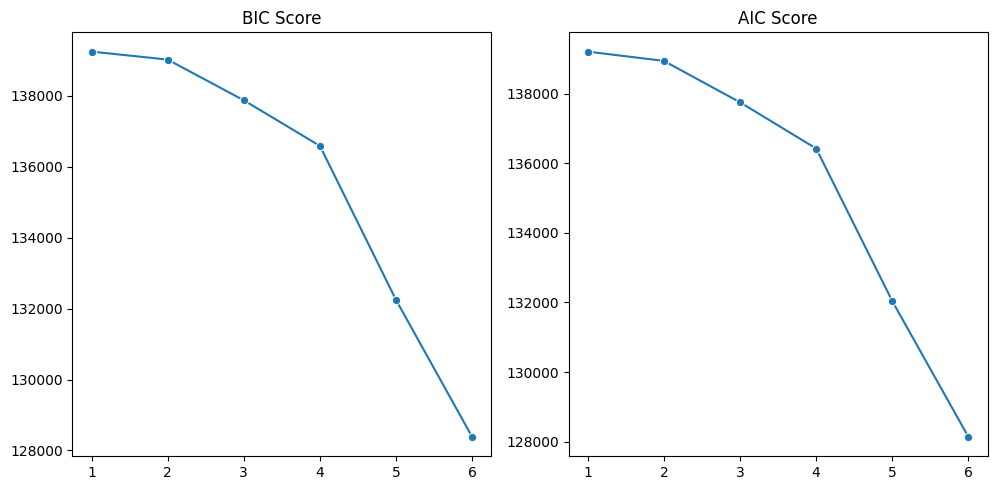

In [ ]:
plt.figure(figsize=(20, 5))

# BIC Plot
plt.subplot(1, 4, 1)
sns.lineplot(x=ks, y=bics, marker='o')
plt.title('BIC Score')

# AIC Plot
plt.subplot(1, 4, 2)
sns.lineplot(x=ks, y=aics, marker='o')
plt.title('AIC Score')


plt.tight_layout()
plt.show()

In [33]:
sb = np.mean(aics)
tb = np.mean(bics)

In [34]:
print(f"Mean difference in AIC - BIC compared to relative size: {np.mean([abs(x - aics[idx])/np.mean([sb, tb])for idx,x in enumerate(bics)])}")

Mean difference in AIC - BIC compared to relative size: 0.0013227642839558666


The optimal value for the components in terms of BIC and AIC is 6, log-likelihood also gives the same $K$

In [ ]:
dfr['profile'].value_counts()

2    3232
0    2146
4    1292
3     825
5     670
1     530
Name: profile, dtype: int64

3-d version

In [35]:
! pip install plotly

In [36]:
dfr.columns

Index(['UMAP1', 'UMAP2', 'UMAP3', 'profile'], dtype='object')

In [37]:
"""3d version to observe patient profiles"""
import plotly.express as px


dfr.to_csv('Eureca2.0_umapGMM3d.csv')

# Create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(dfr, x='UMAP1', y='UMAP2', z='UMAP3', color='profile', opacity=0.8)

# Update layout for better visibility
fig.update_layout(scene=dict(zaxis=dict(range=[dfr['UMAP3'].min(), dfr['UMAP3'].max()])))

# Show the interactive plot
fig.show()

In [38]:
cdg =  dfr['profile'].value_counts(normalize=True)
cluster_distribution_gmm = dfr['profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-3d):")
print(cdg)

Cluster Distribution (GMM-3d):
5    0.338355
3    0.182634
1    0.165037
2    0.152501
4    0.100518
0    0.060955
Name: profile, dtype: float64


There is a clearly dominant cluster which is displayed in yellow above, and a second dominant cluster which is the one red, that takes in 18% of the samples, they come with their corresponding very weak and slightly weak clusters.

In [39]:
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2', 'UMAP3'])
cluster_covariance_gmm = gmm1.covariances_

print("\nCluster Centers 3-d:")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 3-d:
       UMAP1      UMAP2      UMAP3
0  16.813796  32.048916  -0.344151
1  -5.534697  -5.334327  -3.444857
2   8.139349  -0.402815  10.019885
3   4.313818  16.304095   8.628966
4  13.617477  -8.505348  21.974563
5  14.318565  11.168973   8.763162

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[ 0.02813317  0.00318068 -0.0001763 ]
 [ 0.00318068  0.02536339 -0.00336669]
 [-0.0001763  -0.00336669  0.01666514]]

Cluster 1 Covariance Matrix:
[[ 54.94457727 -17.14968761 -30.36648222]
 [-17.14968761  66.11196102 -11.58413266]
 [-30.36648222 -11.58413266  43.60199007]]

Cluster 2 Covariance Matrix:
[[ 7.3115477  -3.0406947   0.23424473]
 [-3.0406947   1.7871873   0.26118441]
 [ 0.23424473  0.26118441 13.49603672]]

Cluster 3 Covariance Matrix:
[[ 4.90012094e+01  7.77755411e-03 -4.90144134e+00]
 [ 7.77755411e-03  1.21089842e+01 -2.80117340e+00]
 [-4.90144134e+00 -2.80117340e+00  1.19125751e+01]]

Cluster 4 Covariance Matrix:
[[66.46899001 27.36554681 13.0

:The covariance matrices are anisotropic for all clusters, we quantify this using the condition matrix.

In [40]:

# Covariance matrices for each cluster
cluster_covariances = [
    np.array([[0.02813317, 0.00318068, -0.0001763],
              [0.00318068, 0.02536339, -0.00336669],
              [-0.0001763, -0.00336669, 0.01666514]]),

    np.array([[54.94457727, -17.14968761, -30.36648222],
              [-17.14968761, 66.11196102, -11.58413266],
              [-30.36648222, -11.58413266, 43.60199007]]),

    np.array([[7.3115477, -3.0406947, 0.23424473],
              [-3.0406947, 1.7871873, 0.26118441],
              [0.23424473, 0.26118441, 13.49603672]]),

    np.array([[49.0012094, 0.00777755, -4.90144134],
              [0.00777755, 12.1089842, -2.8011734],
              [-4.90144134, -2.8011734, 11.9125751]]),

    np.array([[66.46899001, 27.36554681, 13.01682637],
              [27.36554681, 50.32681389, 23.89030354],
              [13.01682637, 23.89030354, 18.75484318]]),

    np.array([[38.10527249, 5.44296964, -7.80104086],
              [5.44296964, 14.93421584, 9.02114521],
              [-7.80104086, 9.02114521, 44.22624854]])
]

# Compute and print the condition number for each covariance matrix
for i, covariance_matrix in enumerate(cluster_covariances):
    condition_number = np.linalg.cond(covariance_matrix)
    print(f"Condition number for Cluster {i}: {condition_number}")


Condition number for Cluster 0: 1.9756386274897484
Condition number for Cluster 1: 7.471626246867081
Condition number for Cluster 2: 31.20336116536273
Condition number for Cluster 3: 5.58835858048402
Condition number for Cluster 4: 16.248070783254747
Condition number for Cluster 5: 4.847771945525963


We observe that cluster 0's condition matrix is quite close to 1, but the rest are really far off, meaning they are very anisotropic.

2-D version


In [ ]:
# READING DATA
# dfr = pd.read_csv('Eureca2.0_umapGMM.csv')
# dfr.drop('ordered_profile', axis=1, inplace=True)

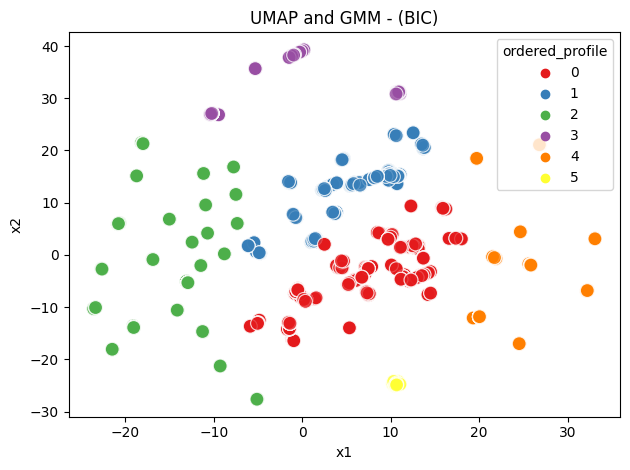

In [ ]:
# 2D

# results without decision regions

cdg=  dfr['profile'].value_counts(normalize=True)
oci = cdg.index
dfr2 = dfr.copy()

dfr2['ordered_profile'] = dfr2['profile'].map(dict(zip(oci, range(len(oci)))))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='ordered_profile', data=dfr2, palette="Set1", s=100, alpha=0.8)
plt.title('UMAP and GMM - (BIC)')
plt.xlabel('x1')
plt.ylabel('x2')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


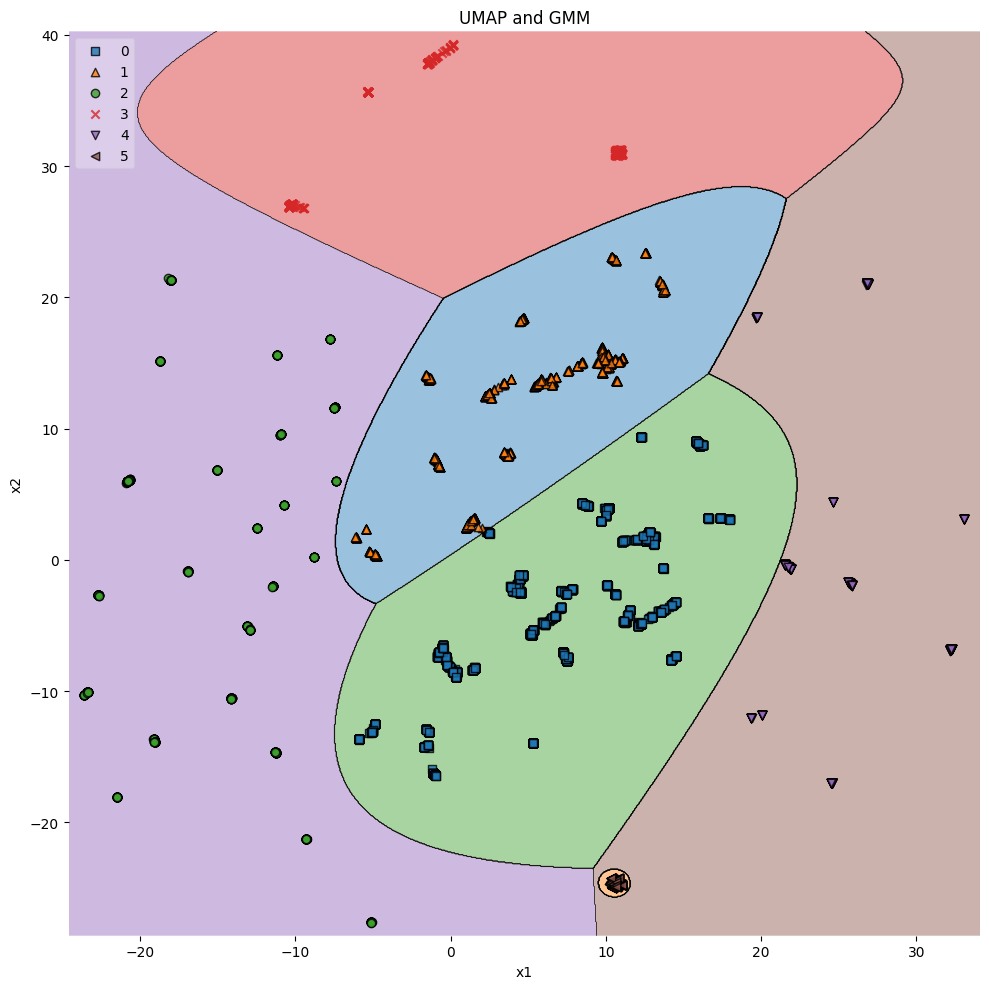

In [ ]:
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize=(10, 10))

# Plot for ordered_profile

plot_decision_regions(embeddings, dfr2['ordered_profile'].values, clf=gmm, legend=2)
plt.title('UMAP and GMM')
plt.xlabel('x1')
plt.ylabel('x2')



# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We now commence by analyzing the results.

In [ ]:
cluster_distribution_gmm = dfr2['ordered_profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-2d-BIC):")
print(cdg)

Cluster Distribution (GMM-2d-BIC):
2    0.371708
0    0.246809
4    0.148591
3    0.094882
5    0.077056
1    0.060955
Name: profile, dtype: float64


We observe two main profiles which take up way more samples than a uniform distribution, those being 2 and 4, taking over 60% of the samples betweem them and with those samples in excess being missing from the rest of the profiles. The 4th cluster is close to uniform but the rest are really far off, needing as they do not even reach 10% of samples.

In [ ]:
# 2d
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2'])
cluster_covariance_gmm = gmm.covariances_

print("\nCluster Centers 2-d (GMM-BIC):")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 2-d (GMM-BIC):
       UMAP1      UMAP2
0   5.040386  12.313508
1  10.570436 -24.614817
2   8.021598  -2.993614
3   2.191881  31.985415
4 -15.268385   0.451230
5  26.001468   1.212527

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[28.67024137 25.34440141]
 [25.34440141 36.3030548 ]]

Cluster 1 Covariance Matrix:
[[ 0.0326587  -0.00053441]
 [-0.00053441  0.03543186]]

Cluster 2 Covariance Matrix:
[[36.89044814 21.44397452]
 [21.44397452 31.04249388]]

Cluster 3 Covariance Matrix:
[[77.76060096  2.29989547]
 [ 2.29989547 15.94149931]]

Cluster 4 Covariance Matrix:
[[ 33.67999662  -2.46055837]
 [ -2.46055837 190.96220377]]

Cluster 5 Covariance Matrix:
[[ 19.83295824  -4.05905372]
 [ -4.05905372 153.86030674]]


In the same manner as before, we are interested in the condition numbers of the covariance matrices.



In [41]:
cluster_covariances = [
    np.array([[28.67024137, 25.34440141],
              [25.34440141, 36.3030548]]),

    np.array([[0.0326587, -0.00053441],
              [-0.00053441, 0.03543186]]),

    np.array([[36.89044814, 21.44397452],
              [21.44397452, 31.04249388]]),

    np.array([[77.76060096, 2.29989547],
              [2.29989547, 15.94149931]]),

    np.array([[33.67999662, -2.46055837],
              [-2.46055837, 190.96220377]]),

    np.array([[19.83295824, -4.05905372],
              [-4.05905372, 153.86030674]])
]

# Compute and print the condition number for each covariance matrix
for i, covariance_matrix in enumerate(cluster_covariances):
    condition_number = np.linalg.cond(covariance_matrix)
    print(f"Condition number for Cluster {i}: {condition_number}")

Condition number for Cluster 0: 8.476137889667188
Condition number for Cluster 1: 1.091279706093012
Condition number for Cluster 2: 4.512218196114549
Condition number for Cluster 3: 4.909547643993133
Condition number for Cluster 4: 5.677529744036272
Condition number for Cluster 5: 7.812380521139632


Cluster 1 has an isotropic variance, the rest however have an anisotropic variance, in particular cluster 0 is the most anisotropic case with $cond = 8.47$

#### UMAP + KMEANS

Fitting KMeans to 2-d and 3-d data obtained through UMAP based on optimal silhoutte score

In [ ]:
wss = []  # within-cluster sum of squares
sscores = []  # silhouette scores
ks = range(2, 8)  # Adjust the range based on your needs

for n_clusters in ks:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1000)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    wss.append(kmeans.inertia_)  # Inertia is the WSS
    sscores.append(ss(embeddings, labels))

optimal_k_wss = ks[np.argmin(wss)]

# Find the optimal number of clusters based on silhouette score
optimal_k_silhouette = ks[np.argmax(sscores)]

# KMeans clustering with optimal_k_silhouette
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=1000)
labels_silhouette = kmeans_silhouette.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2', 'UMAP3'])


In [ ]:
dfr['profile'] = labels_silhouette

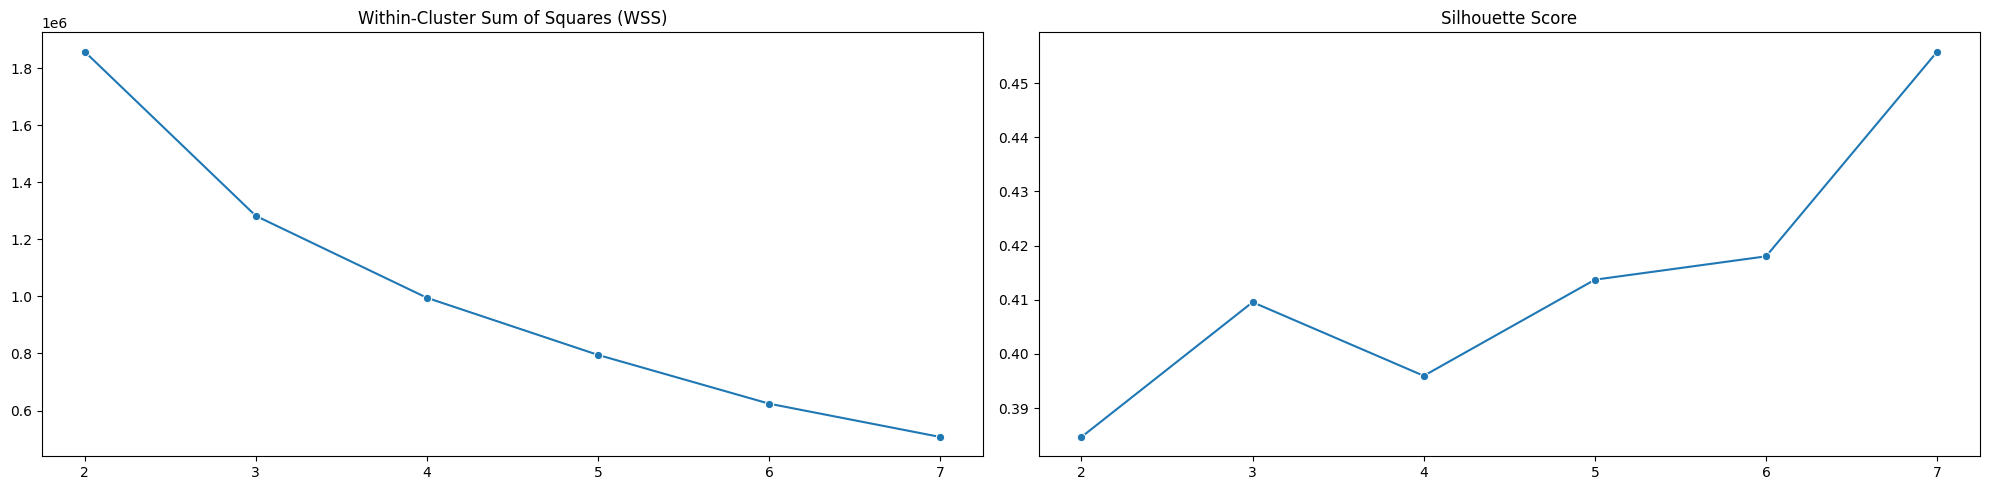

In [ ]:

# Plotting
plt.figure(figsize=(20, 5))

# WSS Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=ks, y=wss, marker='o')
plt.title('Within-Cluster Sum of Squares (WSS)')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=ks, y=sscores, marker='o')
plt.title('Silhouette Score')


plt.tight_layout()
plt.show()


In [ ]:
# setting clf as gmm, we can observe kmeans groups on gmm with k=3
# setting clf as gmm1, we can osbserve kmeans groups on gmm with k=6
# plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=gmm, legend=2)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


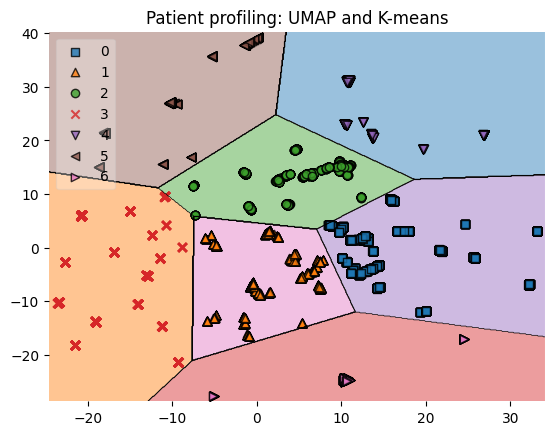

In [ ]:
# KMeans clustering with optimal_k_wss Plot

cdg =  dfr['profile'].value_counts(normalize=True)
ordered_cluster_indices = cdg.index
dfr['ordered_profile'] = dfr['profile'].map(dict(zip(ordered_cluster_indices, range(len(ordered_cluster_indices)))))
plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=kmeans_silhouette, legend=2)
# sns.scatterplot(x=dfr.iloc[:, 0], y=dfr.iloc[:, 1], hue=labels_silhouette, palette='viridis')
plt.title(f'Patient profiling: UMAP and K-means')
plt.show()

As K-means is in fact a mixture model where isotropic variances and uniform component weights are assumed, the result of clustering through KMeans is very somewhat similar.